# HELP: cutouts access

Cutouts access for the surveys used in HELP. <br>
<br>

1. Read fits images <br>
use images already save on disk (path and filename can be specified in the input parameters) or <br>
use the url of the fits cutout/image (possibility to save the fits file on disk).<br>
<br>
2. Plot the cutout (size specified in the input parameters). Ouput options are:<br>
show the figure or,<br>
save the figure or,<br>
return the data array of the image.<br>

_NB: Surveys below are used in HELP but are not included in this notebook because they have no cutout or no data access_<br>
-  No data image access: COMBO-17, ESIS, INT/WFC, AEGIS/Palomar, SIMES/Spitzer <br>
-  Full fits frame only (no cutout access): IBIS, IRAC EGS, KIDS, SXDS/Subaru, zBootes <br>
-  Other: ATLAS (cutout url hidden), CFHT/DEEP2 (issues with the cutout server, wrong position)

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import herschelhelp.cutouts_server as ctts
from astropy.utils.data import clear_download_cache
%matplotlib inline

## <font color=red>Input parameters</font>

-  __ra, dec__ : lists of positions<br>
-  __bands__: list of filters. By default the list includes all the filters available for a specific survey/instrument.

In [2]:
ra = [191.933512]
dec = [28.07124]

**_Cutout parameters_**:<br>
-  __width_as__: size in arcsec of the cutouts. The default value is 20".<br>
-  __smooth__: gaussian smoothing of the image with sigma=1.0 if set to True. It is useful for removing noise. <br>
-  __cmap__: colour map of the image. Default value is "jet". For other options see: https://matplotlib.org/examples/color/colormaps_reference.html <br>
-  __minmax__: method used to get the vmin and vmax of the image.<br>
minmax="MAD" (default parameter), scales the image  between (median + 5 x sigmaMAD) and (median - 2 x sigmaMAD) <br>
minmax=None, uses the min and max of the image directly <br>
-  __origin__: where to place the [0,0] index of the array on the plot. Default value is "lower". <br>
-  __figTitle__: add a title to the figure is set to True (default value). Title in the form of "{survey} cutouts ({width_as}"x{width_as}") \n ra: {ra:.4f}, dec: {dec:.4f} (J{HHMMSSsDDMMSS})". <br> 

In [3]:
width_as = 20.
smooth = False
cmap = "binary"
minmax = "MAD"
origin = "lower"
figTitle = True

**_Output options_**: <br>
-  __saveFITS__: Save a copy on disk of the fits image (full image or cutout) in __imDir__ if set to True.<br>
-  __return_val__: return the data array of the image if set to True. Default setting is False.<br>
-  __saveDir__: save the figure to this directory if not None. If __return_val__=False and __saveDir__=None, it will return the figure.<br>

In [4]:
saveFITS = False
return_val = False
saveDir = None

**_Optional parameters_**:<br>
-  __psfmags__: 2D list of magnitudes for each bands (should have the same length than the ra and dec lists). The default value is None. If an array is given, the magnitude will be shown on the plot above the cutout.<br>
-  __imDir__: Directory of the fits images if already save disk. Same path will be used to save the fits image if the __saveFITS__ parameter is set to True. <br>
-  __input_filename__: 2D list of fits image filenames for each bands if saved on disk (should have the same length than the ra and dec lists). Else set to an empty list.<br>
-  __getFullIm__: Download the full fits image and not only a cutout (availbale for some surveys, not all) if set to True.<br>

## <font color=red>List of surveys (by alphabetical order)</font> 
Set to True the survey(s) for which to plot the cutouts

In [25]:
CFHT_MegaPrime = False
CFHT_WIRCam = False
DECaLS = False
DES = False
FLS_KPNO = False
HDFN = False
HSC = False                       # Account required to access public data
HST_ACS = False
HST_WFC3 = False
LegacySurvey = False
NDWFS = False
PanSTARRS = False
SDSS = False
Spitzer_FLS = False
Spitzer_GOODS = False
Spitzer_SDWFS = False
Spitzer_SERVS = False
Spitzer_SEIP = False
Spitzer_SHELA = False
Spitzer_SpIES = False
Spitzer_SpUDS = False
Spitzer_SSDF = False
Spitzer_SWIRE = False
TwoMass = True
UHS = False                      # DR1 data public since 01/08/2018
UKIDSS = False
VISTA = False

## <font color=red>Cutouts</font>

### <font color=purple>2MASS</font>

2MASS cutout(s), band(s): JHK
J-band
   Get the url of the fits file ...
    https://irsa.ipac.caltech.edu/ibe/data/twomass/allsky/allsky/990510n/s016/image/ji0160091.fits.gz?center=191.933512,28.071240&size=20arcsec
   Try to read the fits file ...
     fits file available
   Plot the cutout ...
H-band
   Get the url of the fits file ...
    https://irsa.ipac.caltech.edu/ibe/data/twomass/allsky/allsky/990510n/s016/image/hi0160091.fits.gz?center=191.933512,28.071240&size=20arcsec
   Try to read the fits file ...
     fits file available
   Plot the cutout ...
K-band
   Get the url of the fits file ...
    https://irsa.ipac.caltech.edu/ibe/data/twomass/allsky/allsky/990510n/s016/image/ki0160091.fits.gz?center=191.933512,28.071240&size=20arcsec
   Try to read the fits file ...
     fits file available
   Plot the cutout ...
 Return the figure


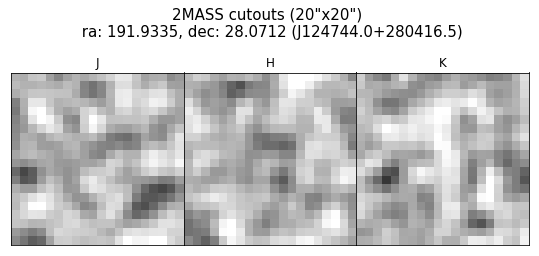

In [26]:
if TwoMass:
    ## Filters
    bands = ['J','H','K']

    ## Optional parameters
    psfmags = None
    imDir, input_filename = "2mass/", []
    getFullIm = False

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_twomass(ra[i], dec[i], bands=bands, psfmags=psfmags,\
                                  imDir=imDir, input_filename=input_filename, getFullIm=getFullIm, saveFITS=saveFITS,\
                                  width_as=width_as, smooth=smooth, minmax=minmax, origin=origin, figTitle=figTitle,\
                                  return_val=return_val, saveDir=saveDir)
        
        # Clear astropy cache
        clear_download_cache()

### <font color=purple>CFHT (MegaPrime & WIRCam)</font>

The following surveys in HELP are using CFHT data: AKARI-NEP (MegaPrime & WIRCam), CFHTLenS (MegaPrime), CFHTLS-Deep (MegaPrime), CFHTLS-Wide (MegaPrime), RCSLenS (MegaPrime), SpARCS (MegaPrime, ugrz), UltraDeep-Ks-GOODS-N (WIRCam K), VICS82 (WIRCam, JK), VIPERS-MLS (MegaPrime & WIRCAM), WIRDS (WIRCam). <br>

**_CFHT (MegaPrime) parameters_**:<br>
-  __optFiltersGen__: version of the MegaPrime filters (1stGen, 3rdGen or both)

In [7]:
if CFHT_MegaPrime:
    ## Filters & Instrument
    bands = ["u", "g", "r", "i", "z"]
    instrument = "MegaPrime"
    
    ## CFHT parameters
    optFiltersGen = "both"
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "cfht/",

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_cfht(ra[i], dec[i], bands=bands, instrument=instrument, optFiltersGen=optFiltersGen,psfmags=psfmags,\
                               imDir=imDir, input_filename=input_filename, getFullIm=getFullIm, saveFITS=saveFITS,\
                               width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                               figTitle=figTitle, return_val=return_val, saveDir=saveDir) 
        
        # Clear astropy cache
        clear_download_cache()

In [8]:
if CFHT_WIRCam:
    ## Filters & Instrument
    bands = ["Y", "J", "H", "K"]
    instrument = "WIRCam"
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "cfht/", []
    getFullIm = False

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_cfht(ra[i], dec[i], bands=bands, instrument=instrument, optFiltersGen=optFiltersGen,psfmags=psfmags,\
                               imDir=imDir, input_filename=input_filename, getFullIm=getFullIm, saveFITS=saveFITS,\
                               width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                               figTitle=figTitle, return_val=return_val, saveDir=saveDir) 
        
        # Clear astropy cache
        clear_download_cache()

### <font color=purple>DECaLS</font>

**_DECaLS parameters_**:<br>
-  __dr__: DECaLS data release
- __brickid__: brickid of the DECaLS observation (if known, else None)

In [9]:
if DECaLS:
    ## Filters 
    bands = ["g", "r", "z"]
    
    ## DECaLS parameters:
    dr = 5
    brickid = None
    
    ## Optional parameters
    psfmags = None
    imDir = "decals/"
    getFullIm = False

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_decals(ra[i], dec[i], bands=bands, dr=dr, psfmags=psfmags, brickid=brickid,\
                                 getFullIm=getFullIm, imDir=imDir, saveFITS=saveFITS,\
                                 width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                                 figTitle=figTitle, return_val=return_val, saveDir=saveDir)
        
        # Clear astropy cache
        clear_download_cache()

### <font color=purple>DES</font>

Need python pyvo module.<br>

**_DES parameters_**:<br>
-  __dr__: DES data release

In [10]:
if DES:
    ## Filters 
    bands = ["g", "r", "i", "z", "y"]
    
    ## DES parameters:
    dr = 1
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "des/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_des(ra[i], dec[i], bands=bands, dr=dr, psfmags=psfmags,\
                                 imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                                 width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                                 figTitle=figTitle, return_val=return_val, saveDir=saveDir)
        
        # Clear astropy cache
        clear_download_cache()

### <font color=purple>FLS-KPNO</font>

In [11]:
if FLS_KPNO:
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "fls-kpno/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_flsKPNO(ra[i], dec[i], bands=["R"], psfmags=psfmags,\
                                  imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                                  width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                                  figTitle=figTitle, return_val=return_val, saveDir=saveDir)
        
        # Clear astropy cache
        clear_download_cache()

### <font color=purple>Hawaii Hubble Deep Field North (HDF-N)</font>

Need python astroquery.skyview module

In [12]:
if HDFN:
    ## Filters
    bands = ["U","B","V","R","I","z","HK"]
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "hdfn/", []
    getFullIm = False

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_hdfn(ra[i], dec[i], bands=bands, psfmags=psfmags,\
                               imDir=imDir, saveFITS=saveFITS, getFullIm=getFullIm,\
                               width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                               figTitle=figTitle, return_val=return_val, saveDir=saveDir)       
        
        # Clear astropy cache
        clear_download_cache()

### <font color=purple>Hyper Suprime-Cam (HSC) [ACCOUNT REQUIRED]</font> 

An account is required to access public data. To create an account see:<br>
https://hsc-release.mtk.nao.ac.jp/doc/index.php/tools/

In [13]:
if HSC:
    ## Login [ID, password]
    login = []
    
    ## Filters
    bands = ["g","r","i","z","y","N816","N921"]
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "hsc/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_hsc(ra[i], dec[i], bands=bands, login=login,\
                              psfmags=psfmags, imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                              width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                              figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()

### <font color=purple>HST (ACS & WFC3)</font> 


In [14]:
if HST_ACS:
    ## Filters & instrument
    bands = ["F435W","F606W","F775W","F814W","F850LP"]
    instrument = "ACS"
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "hst/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_hst(ra[i], dec[i], bands=bands, instrument=instrument, psfmags=psfmags,\
                              imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                              width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                              figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()

In [15]:
if HST_WFC3:
    ## Filters & instrument
    bands = ["F105W","F125W","F140W","F160W","F098M"]
    instrument = "WFC3"
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "hst/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_hst(ra[i], dec[i], bands=bands, instrument=instrument, psfmags=psfmags,\
                              imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                              width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                              figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()

### <font color=purple>Legacy Survey (BASS gr-bands & MzLS z-band)</font> 

**_Legacy Survey parameters_**:<br>
-  __dr__: Legacy Survey data release

In [16]:
if LegacySurvey:
    ## Filters 
    bands = ["g","r","z"]
    
    ## Legacy Survey parameters
    dr = 6

    ## Optional parameters
    psfmags = None
    imDir, input_filename = "legacysurvey/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_legacySurvey(ra[i], dec[i], bands=bands, dr=dr, psfmags=psfmags,\
                                       imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                                       width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                                       figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()

### <font color=purple>The NOAO Deep Wide-Field Survey (NDWFS)</font> 

In [17]:
if NDWFS:
    ## Filters 
    bands = ['Bw','R','I','K']

    ## Optional parameters
    psfmags = None
    imDir, input_filename = "ndwfs/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_ndwfs(ra[i], dec[i], bands=bands, psfmags=psfmags,\
                                imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                                width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                                figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()

### <font color=purple>Pan-STARRS</font> 

In [18]:
if PanSTARRS:
    ## Filters 
    bands = ["g","r","i","z","y"]

    ## Optional parameters
    psfmags = None
    imDir = "ps1/"
    getFullIm = False

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_ps1(ra[i], dec[i], bands=bands, psfmags=psfmags, 
                              imDir=imDir, getFullIm=getFullIm, saveFITS=saveFITS,\
                              width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                              figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()

### <font color=purple>SDSS</font> 

**_SDSS parameters_**:<br>
-  __dr__: SDSS data release
-  __objid__: SDSS objid (if known, else None)

In [19]:
if SDSS:
    ## Filters 
    bands = ['u','g','r','i','z']
    
    ## SDSS parameters
    dr = 12
    objid = None
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "sdss/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_sdss(ra[i], dec[i], bands=bands, objid=objid, psfmags=psfmags,\
                               imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                               width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                               figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()

### <font color=purple>Spitzer</font> 

__Spitzer First Look Survey (FLS)__<br>
https://irsa.ipac.caltech.edu/data/SPITZER/FLS/

In [20]:
if Spitzer_FLS:
    ## Filters & dataset
    bands = ['I1', 'I2', 'I3', 'I4']
    dataset = "FLS"
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "spitzer/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_spitzer(ra[i], dec[i], bands=bands, dataset=dataset, psfmags=psfmags,\
                                  imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                                  width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                                  figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()

__Spitzer Great Observatories Origins Deep Survey (GOODS)__<br>
https://irsa.ipac.caltech.edu/data/SPITZER/GOODS/

In [21]:
if Spitzer_GOODS:
    ## Filters & dataset
    bands = ['I1', 'I2', 'I3', 'I4']
    dataset = "GOODS"
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "spitzer/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_spitzer(ra[i], dec[i], bands=bands, dataset=dataset, psfmags=psfmags,\
                                  imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                                  width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                                  figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()

__Spitzer Deep, Wide-Field Survey (SDWFS)__<br>
https://irsa.ipac.caltech.edu/data/SPITZER/SDWFS/

In [22]:
if Spitzer_SDWFS:
    ## Filters & dataset
    bands = ['I1', 'I2', 'I3', 'I4']
    dataset = "SDWFS"
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "spitzer/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_spitzer(ra[i], dec[i], bands=bands, dataset=dataset, psfmags=psfmags,\
                                  imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                                  width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                                  figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()

__Spitzer Extragalactic Representative Volume Survey (SERVS)__<br>
https://irsa.ipac.caltech.edu/data/SPITZER/SERVS/

In [23]:
if Spitzer_SERVS:
    ## Filters & dataset
    bands = ['I1', 'I2']
    dataset = "SERVS"
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "spitzer/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_spitzer(ra[i], dec[i], bands=bands, dataset=dataset, psfmags=psfmags,\
                                  imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                                  width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                                  figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()

__Spitzer Enhanced Imaging Products (SEIP)__<br>
Includes Super Mosaics images by combining data from multiple programs/datasets<br>
https://irsa.ipac.caltech.edu/data/SPITZER/Enhanced/SEIP/overview.html

In [24]:
if Spitzer_SEIPS:
    ## Filters & dataset
    bands = ['I1', 'I2', 'I3', 'I4']
    dataset = "SEIP"
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "spitzer/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_spitzer(ra[i], dec[i], bands=bands, dataset=dataset, psfmags=psfmags,\
                                  imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                                  width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                                  figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()

NameError: name 'Spitzer_SEIPS' is not defined

__Spitzer/HETDEX Exploratory Large-Area (SHELA)__<br>
https://irsa.ipac.caltech.edu/data/SPITZER/SHELA/

In [ ]:
if Spitzer_SHELA:
    ## Filters & dataset
    bands = ['I1', 'I2']
    dataset = "SHELA"
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "spitzer/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_spitzer(ra[i], dec[i], bands=bands, dataset=dataset, psfmags=psfmags,\
                                  imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                                  width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                                  figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()

__Spitzer IRAC Equatorial Survey (SpIES)__<br>
https://irsa.ipac.caltech.edu/data/SPITZER/SpIES/

In [ ]:
if Spitzer_SpIES:
    ## Filters & dataset
    bands = ['I1', 'I2']
    dataset = "SpIES"
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "spitzer/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_spitzer(ra[i], dec[i], bands=bands, dataset=dataset, psfmags=psfmags,\
                                  imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                                  width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                                  figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()

__Spitzer UKIDSS Ultra Deep Survey (SpUDS)__<br>
https://irsa.ipac.caltech.edu/data/SPITZER/SpUDS/

In [ ]:
if Spitzer_SpUDS:
    ## Filters & dataset
    bands = ['I1', 'I2', 'I3', 'I4']
    dataset = "SpUDS"
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "spitzer/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_spitzer(ra[i], dec[i], bands=bands, dataset=dataset, psfmags=psfmags,\
                                  imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                                  width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                                  figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()

__SPT-Spitzer Deep Field (SSDF)__<br>
https://irsa.ipac.caltech.edu/data/SPITZER/SSDF/

In [ ]:
if Spitzer_SSDF:
    ## Filters & dataset
    bands = ['I1', 'I2']
    dataset = "SSDF"
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "spitzer/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_spitzer(ra[i], dec[i], bands=bands, dataset=dataset, psfmags=psfmags,\
                                  imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                                  width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                                  figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()

__Spitzer Wide-area InfraRed Extragalactic Survey (SWIRE) __<br>
https://irsa.ipac.caltech.edu/data/SPITZER/SWIRE/

In [ ]:
if Spitzer_SWIRE:
    ## Filters & dataset
    bands = ['I1', 'I2', 'I3', 'I4']
    dataset = "SWIRE"
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "spitzer/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_spitzer(ra[i], dec[i], bands=bands, dataset=dataset, psfmags=psfmags,\
                                  imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                                  width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                                  figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()

### <font color=purple>The UKIRT Hemisphere Survey (UHS)</font> 

**_UHS parameters_**:<br>
-  __database__: UHS data release. Only UHSDR1 availalable so far (August 2018)
-  __wsaLogin__: UHS login details to access proprietary data ([username, password])



In [ ]:
if UHS:
    ## UHS parameters
    database = "UHSDR1"
    wsaLogin = []
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "uhs/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_uhs(ra[i], dec[i], bands=['J'], database=database, wsaLogin=wsaLogin,\
                              psfmags=psfmags, imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                              width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                              figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()

### <font color=purple>The UKIRT InfraRed Deep Sky Surveys (UKIDSS)</font> 

Includes five surveys: <font color=purple> Large Area Survey (LAS), Galactic Plane Survey (GPS), Galactic Clusters Survey (GCS), Deep Extragalactic Survey (DXS) and the Ultra Deep Survey (UDS). </font><br>

**_UKIDSS parameters_**:<br>
-  __database__: UKIDSS data release
-  __programme__: UKIDSS survey name (i.e DXS, GCS, GPS, LAS, UDS)
-  __wsaLogin__: UKIDSS login details to access proprietary data ([username, password, community])<br>
<br>
Need python astroquery.ukidss module

In [ ]:
if UKIDSS:
    ## Filters 
    bands = ['Z','Y','J','H','K']
    
    ## UKIDSS parameters
    database = "UKIDSSDR10PLUS"
    programme = "LAS"              # also available: DXS, GCS, GPS, UDS
    wsaLogin = []
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "ukidss/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_ukidss(ra[i], dec[i], bands=bands, programme=programme, database=database, wsaLogin=wsaLogin,\
                                 psfmags=psfmags, imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                                 width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                                 figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()

### <font color=purple>The Visible and Infrared Survey Telescope for Astronomy (VISTA)</font> 

Includes several surveys, the full list is available here: http://horus.roe.ac.uk:8080/vdfs/VgetImage_form.jsp<br>
Three of them are used in HELP: <font color=purple> the VISTA Hemisphere Survey (VHS),the VISTA Kilo-degree Infrared Galaxy survey (VIKING) and the VISTA Deep Extragalactic Observations (VIDEO).</font><br>

**_VISTA parameters_**:<br>
-  __database__: VISTA data release
-  __survey__: VISTA survey name (as listed in http://horus.roe.ac.uk:8080/vdfs/VgetImage_form.jsp)
-  __wsaLogin__: VISTA login details to access proprietary data ([username, password, community])

In [ ]:
if VISTA:
    ## Filters 
    bands = ["Z","Y","J","H","K"]
    
    ## VISTA parameters
    database = "VHSDR5"
    survey = "VHS"              
    wsaLogin = []
    
    ## Optional parameters
    psfmags = None
    imDir, input_filename = "vista/", []

    
    
    ## Cutouts
    for i in range(len(ra)):
        out = ctts.cutout_vista(ra[i], dec[i], bands=bands, survey=survey, database=database, wsaLogin=wsaLogin,\
                                 psfmags=psfmags, imDir=imDir, input_filename=input_filename, saveFITS=saveFITS,\
                                 width_as=width_as, smooth=smooth, cmap=cmap, minmax=minmax, origin=origin,\
                                 figTitle=figTitle, return_val=return_val, saveDir=saveDir)
           
        # Clear astropy cache
        clear_download_cache()